<a href="https://colab.research.google.com/github/namnitha/CE888-Data-Science/blob/master/Lab8/Newdataset_TransferLearning_Example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!git clone https://github.com/sagihaider/CE888_2020.git

fatal: destination path 'CE888_2020' already exists and is not an empty directory.


In [13]:
import os

os.environ['KAGGLE_USERNAME'] = "namnitha" 

os.environ['KAGGLE_KEY'] = "90ceb5b09eaa184f556d4577eb017b49"
!kaggle datasets download -d pmigdal/alien-vs-predator-images

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
# Upload data
from zipfile import ZipFile
file_name = "/content/alien-vs-predator-images.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


Install packages tensorflow 1.3.0 and keras 2.0.7

In [15]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

In [0]:
import numpy as np
import os
import time
from CE888_2020.Lab_8.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
#%% Load an elephant image as an example and see the image-processing

img_path = '/content/CE888_2020/Lab_8/elephant.jpg' # image name
img = image.load_img(img_path, target_size=(224, 224)) # load image
x = image.img_to_array(img) # convert image to array
print (x.shape)
x = np.expand_dims(x, axis=0) # expand dimension
print (x.shape)
x = preprocess_input(x)
print('Input image shape:', x.shape)

(224, 224, 3)
(1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [0]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/alien_vs_predator_thumbnails/data/train'
data_dir_list = os.listdir(data_path)

In [20]:
img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		# print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-predator

Loaded the images of dataset-alien

(694, 1, 224, 224, 3)
(1, 694, 224, 224, 3)
(694, 224, 224, 3)


In [21]:
# Define the number of classes
num_classes = 2
print(img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:347]=0
labels[347:]=1


names = ['predator','alien']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


694


In [22]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

552370176/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [23]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.layers[3].trainable
custom_vgg_model.summary()

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 555 samples, validate on 139 samples
Epoch 1/2
555/555 [==============================] - 1125s - loss: 0.7100 - acc: 0.7676 - val_loss: 0.5543 - val_acc: 0.7770
Epoch 2/2
555/555 [==============================] - 1128s - loss: 0.1998 - acc: 0.9171 - val_loss: 0.2500 - val_acc: 0.8993
Training time: -2254.663114309311
139/139 [==============================] - 226s    
[INFO] loss=0.2500, accuracy: 89.9281%


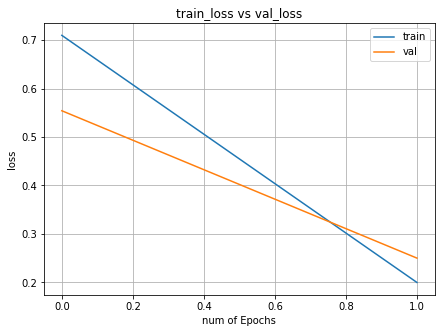

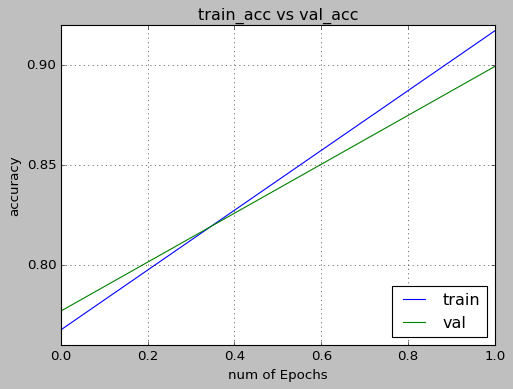

In [26]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])